In [8]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# helper functions

In [9]:
def convertColumnNameToCammelCase(dataFrame:pd.DataFrame, inplace:bool=False):
    '''
        convert column name to cammelCase
        Return None if inplace==True
            DataFrame with column names in cammelCase
    '''
    columnNameMapping = dict()
    for initColumnName in dataFrame.columns:
        initColumnName: str
        if len(initColumnName.split(' ')) == 2:
            firstPart = initColumnName.split(' ')[0].lower()
            secondPart = initColumnName.split(' ')[1].lower().capitalize()
            columnNameMapping[initColumnName] = firstPart+secondPart
        else:
            columnNameMapping[initColumnName] = initColumnName.lower()
    newDfOrNone = dataFrame.rename(columns=columnNameMapping, inplace=inplace)
    return newDfOrNone


# Data preprocessing

In [26]:
# read csv and convert date time correct format
transactionDataframe = pd.read_csv('../data/transaction_cleaned.csv')
# replace column Name with cammelCase
convertColumnNameToCammelCase(transactionDataframe, True)

transactionDataframe['transactionDate'] = pd.to_datetime(transactionDataframe['transactionDate'], dayfirst=True)
# add day of year column 1 to 366
transactionDataframe['dayOfYear'] = transactionDataframe['transactionDate'].dt.dayofyear
# add day of week: 1to7 1: monday, 2: tuesday...
transactionDataframe['dayOfWeek'] = transactionDataframe['transactionDate'].dt.dayofweek + 1 
# week of the year 1 to 53
transactionDataframe['weekOfYear'] = transactionDataframe['transactionDate'].dt.isocalendar().week

# add isCredit: reference: https://stackoverflow.com/questions/71000585/create-a-new-column-in-pandas-dataframe-based-on-the-nan-values-in-another-col
transactionDataframe['isCredit'] = transactionDataframe['creditAmount'].isna()==False
# add transaction Amount based on isCredit, if isCredit is true, use Credit Amount, else use Debit Amount
transactionDataframe['transactionAmount'] = transactionDataframe.apply(lambda row: row.creditAmount if row['isCredit'] else row.debitAmount, axis=1)
transactionDataframe['categoryNumerical'] = transactionDataframe['category'].replace(set(transactionDataframe['category']), [ i for i in range(len(set(transactionDataframe['category'])))])

In [27]:
transactionDataframe

,unnamed:0,transactionNumber,transactionDate,transactionType,transactionDescription,debitAmount,creditAmount,balance,category,locationCity,locationCountry,dayOfYear,dayOfWeek,weekOfYear,isCredit,transactionAmount,categoryNumerical
0,0,1,2022-07-25,BP,SAVE THE CHANGE,3.11,NaN,541.43,Savings,Nottingham,Uk,206,1,30,False,3.11,28
1,1,2,2022-07-25,DEB,LIDL GB NOTTINGHA,15.02,NaN,544.54,Groceries,Nottingham,Uk,206,1,30,False,15.02,5
2,2,3,2022-07-25,DEB,NON-GBP PURCH FEE,0.50,NaN,559.56,Others,Nottingham,Uk,206,1,30,False,0.50,19
3,3,4,2022-07-25,DEB,NON-GBP TRANS FEE,0.37,NaN,560.06,Others,Nottingham,Uk,206,1,30,False,0.37,19
4,4,5,2022-07-25,DEB,TRAVELIUM LLC,12.59,NaN,560.43,NaN,NaN,NaN,206,1,30,False,12.59,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6562,6562,6563,2015-07-28,DEB,Amazon Svcs Europe,5.49,NaN,7187.57,Amazon,Swansea,Uk,209,2,31,False,5.49,2
6563,6563,6564,2015-07-28,BP,SAVE THE CHANGE,1.10,NaN,7193.06,Savings,Swansea,Uk,209,2,31,False,1.10,28
6564,6564,6565,2015-07-27,DEB,Amazon UK Marketpl,6.39,NaN,7194.16,Amazon,Swansea,Uk,208,1,31,False,6.39,2
6565,6565,6566,2015-07-27,DEB,JS ONLINE GROCERY,316.51,NaN,7200.55,Groceries,Swansea,Uk,208,1,31,False,316.51,5


# apply k-means on transaction amount and dayofyear

In [12]:
# assert the number of na in transactin amount and day of year is 0
assert(transactionDataframe.transactionAmount.isna().sum()==0)
assert(transactionDataframe.dayOfYear.isna().sum()==0)

### put data into numpy array

In [13]:
x1 = transactionDataframe.transactionAmount.to_numpy() # amount
x2 = transactionDataframe.dayOfYear.to_numpy() # day of year
x3 = transactionDataframe.weekOfYear.to_numpy() # week of year
x4 = transactionDataframe.dayOfWeek.to_numpy() # day of week
X = np.dstack((x1,x2,x3,x4))[0]

In [14]:
X

array([[3.11, 206, 30, 1],
       [15.02, 206, 30, 1],
       [0.5, 206, 30, 1],
       ...,
       [6.39, 208, 31, 1],
       [316.51, 208, 31, 1],
       [1000.0, 208, 31, 1]], dtype=object)

### run k-mean

In [30]:
# reference: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
kmeans = KMeans(n_clusters=20, random_state=0).fit(X)

In [31]:
# add k-means category into the dataframe
transactionDataframe['cluster'] = kmeans.labels_

c:\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



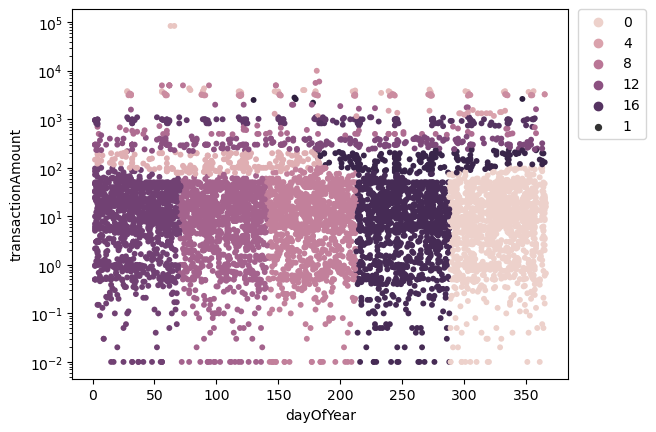

In [32]:
# reference https://www.statology.org/seaborn-legend-position/
sb.scatterplot(transactionDataframe['dayOfYear'], y=transactionDataframe['transactionAmount'], hue=kmeans.labels_, size=1, linewidth=0)
plt.yscale('log')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

# plot use pcp

In [35]:
import plotly.express as px

fig = px.parallel_coordinates(transactionDataframe, color='categoryNumerical')
fig.show()